# Подготовка данных

In [1]:
import numpy as np # импортируем библиотеку NumPy
import pandas as pd # импорт пакета Pandas
import datetime as dt
from pylab import mpl, plt # импорт библиотеки Matplotlib

In [2]:
plt.style.use('seaborn') # настройка стиля диаграмм
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
# загрузка данных из CSV-файла
# Столбцы для использования в качестве меток строки файла DataFrame либо даны как string name или индекс столбца.
# Если задана последовательность INT / STR, используется многоиндекс.
# Примечание: index_col = false может использоваться для форсирования Pands не использовать первый столбец как индекс,
# например, когда у вас есть неправильный файл с разделителями в конце каждой строки.
# Функция читает файл, в котором данные о последней свече находятся в первой строке 
raw = pd.read_csv('c:\SBERBANK\QUIK_x64\lua\SiH2\SiH2_13.1.2022.csv', index_col=0, parse_dates=False)

In [4]:
raw.info() # информация о файле

<class 'pandas.core.frame.DataFrame'>
Index: 3753 entries, 2022-1-13 to 2021-12-16
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    3753 non-null   object 
 1   Open    3753 non-null   float64
 2   High    3753 non-null   float64
 3   Low     3753 non-null   float64
 4   Close   3753 non-null   float64
 5   Volume  3753 non-null   float64
dtypes: float64(5), object(1)
memory usage: 205.2+ KB


In [5]:
symbol = 'Close' # т.к. нам нужны цены закрытия пятиминутных свечей берём данные из колонки Close

In [6]:
m5_close = raw[symbol] # сохраняем серию в переменную с наиболее подходящим и информативным названием

In [7]:
# обратить внимание, что дата всегда присутствует
m5_close.head()

Date
2022-1-13    77498.0
2022-1-13    77454.0
2022-1-13    77440.0
2022-1-13    77494.0
2022-1-13    77461.0
Name: Close, dtype: float64

In [8]:
# нам необходимо, чтобы самые старые свечи были в начале серии, поэтому применяем соответствующую операцию для срезов: 
reverse_m5_close = m5_close[::-1]

In [9]:
# смотрим на каждом этапе какие данные в каком виде
reverse_m5_close.head()

Date
2021-12-16    75204.0
2021-12-16    75190.0
2021-12-16    75196.0
2021-12-16    75158.0
2021-12-16    75134.0
Name: Close, dtype: float64

In [10]:
# формирование подмножества данных и исключение нечисловых значений (NaN))
data = (pd.DataFrame(reverse_m5_close).dropna())

In [11]:
data.head()

,Close
Date,
2021-12-16,75204.0
2021-12-16,75190.0
2021-12-16,75196.0
2021-12-16,75158.0
2021-12-16,75134.0


In [12]:
# расчёт логарифмической доходности
data['Доходность'] = np.log(data/data.shift(1))

In [13]:
data['Доходность'].head()

Date
2021-12-16         NaN
2021-12-16   -0.000186
2021-12-16    0.000080
2021-12-16   -0.000505
2021-12-16   -0.000319
Name: Доходность, dtype: float64

In [14]:
# всегда применяем после shift, т.к. после shift появляются нечисловые значения NaN
data.dropna(inplace=True)

In [15]:
data.head()

,Close,Доходность
Date,,
2021-12-16,75190.0,-0.000186
2021-12-16,75196.0,0.000080
2021-12-16,75158.0,-0.000505
2021-12-16,75134.0,-0.000319
2021-12-16,75132.0,-0.000027


In [16]:
# Функция sign() является указателем на знак числа. Если число со знаком минус, то возвращает -1, если с плюсом, то 1
# Функция astype() преобразует в указанный тип данных, в данном случае int
data['Направление'] = np.sign(data['Доходность']).astype(int)

In [17]:
data['Направление'].head()

Date
2021-12-16   -1
2021-12-16    1
2021-12-16   -1
2021-12-16   -1
2021-12-16   -1
Name: Направление, dtype: int32

In [18]:
lags = 5 # поменяли количество 2 на 5

In [19]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Доходность'].shift(lag) # обратить внимание на каком этапе появляются data[col]
        cols.append(col)

In [20]:
create_lags(data)

In [21]:
data.dropna(inplace=True)

In [22]:
data.head()

,Close,Доходность,Направление,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2021-12-16,75136.0,0.000053,1,-0.000027,-0.000319,-0.000505,0.000080,-0.000186
2021-12-16,75159.0,0.000306,1,0.000053,-0.000027,-0.000319,-0.000505,0.000080
2021-12-16,75177.0,0.000239,1,0.000306,0.000053,-0.000027,-0.000319,-0.000505
2021-12-16,75200.0,0.000306,1,0.000239,0.000306,0.000053,-0.000027,-0.000319
2021-12-16,75180.0,-0.000266,-1,0.000306,0.000239,0.000306,0.000053,-0.000027


В этом разделе мы воспользуемся алгоритмами машинного обучения (см. главу 13) для решения задачи о прогнозировании направления движения цен на финансовых рынках. С учетом примеров из предыдущих разделов применить логистическую регрессию, наивный байесовский классификатор и метод опорных векторов будет не намного сложнее, чем в случае обработки небольшого набора выборочных данных.

# Пять бинарных признаков

Для начала напишем код обучения моделей на основе пяти бинарных признаков и получения соответствующих значений позиций.

In [23]:
# импортируем все необходимые библиотеки
from sklearn import linear_model # линейная модель
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [24]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append (col_bin )

In [25]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [26]:
data[cols_bin + ['Направление']].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,Направление
Date,,,,,,
2021-12-16,0,0,0,1,0,1
2021-12-16,1,0,0,0,1,1
2021-12-16,1,1,0,0,0,1
2021-12-16,1,1,1,0,0,1
2021-12-16,1,1,1,1,0,-1


In [27]:
grouped = data.groupby(cols_bin + ['Направление'])
grouped.size()

lag_1_bin  lag_2_bin  lag_3_bin  lag_4_bin  lag_5_bin  Направление
0          0          0          0          0          -1             30
                                                        0              1
                                                        1             35
                                            1          -1             36
                                                        1             70
                                                                      ..
1          1          1          1          0           0              3
                                                        1             61
                                            1          -1             64
                                                        0              1
                                                        1             63
Length: 92, dtype: int64

In [28]:
res = grouped['Направление'].size().unstack(fill_value=0)

In [29]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [30]:
res.style.apply(highlight_max, axis=1)

In [31]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1 ) == 2, -1, 1)

In [32]:
(data['Направление'] == data['pos_freq']).value_counts()

False    1908
True     1839
dtype: int64

In [33]:
data['strat_freq'] = data['pos_freq'] * data['Доходность']

In [34]:
data[['Доходность', 'strat_freq']].sum().apply(np.exp)

Доходность    1.031491
strat_freq    1.027477
dtype: float64

In [35]:
C = 1

In [36]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C) 
}

In [37]:
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin], data['Направление'])
            for model in models.keys()}

In [38]:
fit_models(data)

In [39]:
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin]) 

In [40]:
derive_positions(data)

In [41]:
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['Доходность']
        sel.append(col)
    sel.insert(0, 'Доходность')

In [42]:
evaluate_strats(data)

In [43]:
sel.insert(1, 'strat_freq') 

In [44]:
data[sel].sum().apply(np.exp)

Доходность        1.031491
strat_freq        1.027477
strat_log_reg     0.977182
strat_gauss_nb    0.977182
strat_svm         1.121107
dtype: float64

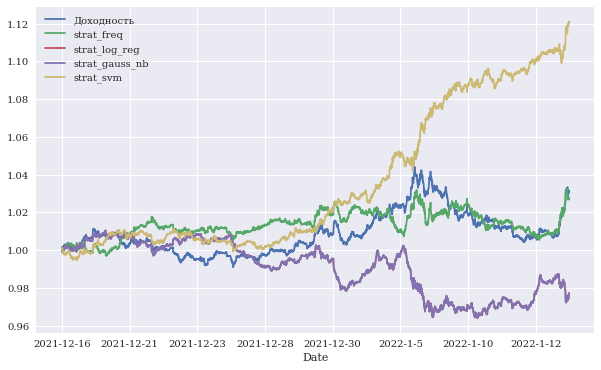

In [45]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Пять дискретизированных признаков

In [46]:
mu = data['Доходность'].mean()
v = data['Доходность'].std()

In [47]:
bins = [mu - v, mu, mu + v]
bins

[-0.0004809767608532843, 8.274769955568862e-06, 0.000497526300764422]

In [48]:
create_bins(data, bins)

In [49]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2021-12-16,1,1,0,2,1
2021-12-16,2,1,1,0,2
2021-12-16,2,2,1,1,0
2021-12-16,2,2,2,1,1
2021-12-16,2,2,2,2,1


In [50]:
fit_models(data)

In [51]:
derive_positions(data)

In [52]:
evaluate_strats(data)

In [53]:
data[sel].sum().apply(np.exp) 

Доходность        1.031491
strat_log_reg     0.982237
strat_gauss_nb    0.990396
strat_svm         1.239016
dtype: float64

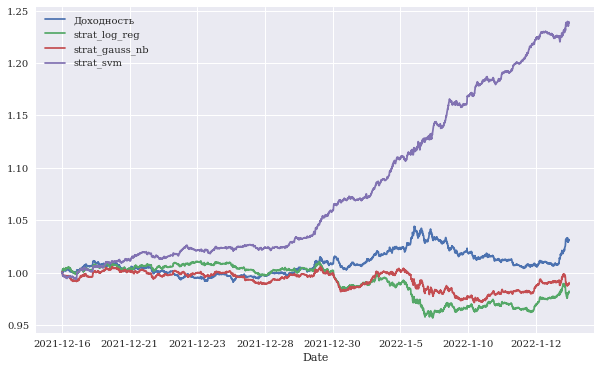

In [54]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Последовательное разделение данных на обучающий и тестовый наборы

In [55]:
split = int(len(data) * 0.5) 

In [56]:
train = data.iloc[:split].copy()

In [57]:
fit_models(train)

In [58]:
test = data.iloc[split:].copy()

In [59]:
derive_positions(test)

In [60]:
evaluate_strats(test)

In [61]:
test[sel].sum().apply(np.exp) 

Доходность        1.020610
strat_log_reg     0.944675
strat_gauss_nb    0.934858
strat_svm         0.951055
dtype: float64

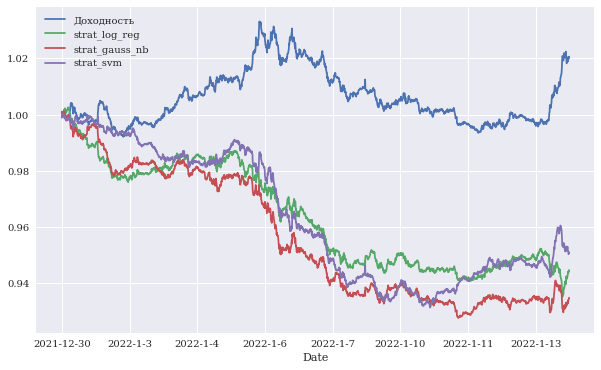

In [62]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Рандомизированное разделение данных на обучающий и тестовый наборы

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
train, test = train_test_split(data, test_size=0.5, shuffle=True, random_state=100)

In [65]:
train = train.copy().sort_index()

In [66]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2021-12-16,2,2,2,2,1
2021-12-16,3,2,2,2,1
2021-12-16,2,2,2,1,1
2021-12-16,2,3,2,1,2
2021-12-16,2,2,2,1,1


In [67]:
test = test.copy().sort_index()

In [68]:
fit_models(train)

In [69]:
derive_positions(test)

In [70]:
evaluate_strats(test)

In [71]:
test[sel].sum().apply(np.exp)

Доходность        1.020265
strat_log_reg     0.967684
strat_gauss_nb    0.968294
strat_svm         0.993735
dtype: float64

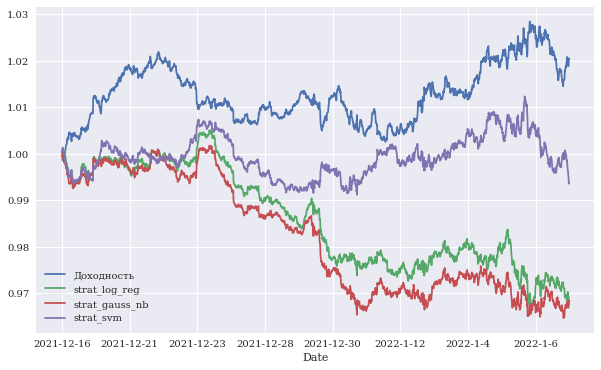

In [72]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Глубокие нейронные сети

Глубокие нейронные сети (Deep Neural Networks — DNN) пытаются моделировать работу человеческого мозга. Они обычно состоят из входного слоя (признаков), выходного слоя (метки) и определенного количества скрытых слоев. Наличие скрытых слоев как раз и делает нейронную сеть глубокой. Такие нейронные сети способны обучаться сложным зависимостям и демонстрировать более высокую эффективность при решении целого ряда задач. В этом контексте обычно говорят не о машинном обучении, а о глубоком обучении.

# DNN и библиотека Scikit-learn

В этом разделемы применим алгоритм MLPClassifier избиблиотеки Scikit-learn, с которым познакомились в главе 13. Сначала он обучается и тестируется на всем наборе данных с использованием дискретизированных признаков. Алгоритм демонстрирует исключительную доходность в пределах выборки, что свидетельствует об огромных возможностях DNN в решении такого рода задач. Но вероятнее всего, мы имеем дело с сильным переобучением, поскольку доходность выглядит неестественно высокой.

In [73]:
from sklearn.neural_network import MLPClassifier

In [74]:
data[cols_bin].head(10)

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2021-12-16,1,1,0,2,1
2021-12-16,2,1,1,0,2
2021-12-16,2,2,1,1,0
2021-12-16,2,2,2,1,1
2021-12-16,2,2,2,2,1
2021-12-16,1,2,2,2,2
2021-12-16,3,1,2,2,2
2021-12-16,0,3,1,2,2
2021-12-16,2,0,3,1,2


In [75]:
data['Направление'].head(10)

Date
2021-12-16    1
2021-12-16    1
2021-12-16    1
2021-12-16    1
2021-12-16   -1
2021-12-16    1
2021-12-16   -1
2021-12-16    1
2021-12-16   -1
2021-12-16   -1
Name: Направление, dtype: int32

In [76]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)

In [77]:
%time model.fit(data[cols_bin], data['Направление']) 

Wall time: 35.3 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [78]:
# прогнозируем ту колонку, которая нам нужна
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [79]:
data['pos_dnn_sk'].head(10)

Date
2021-12-16    1
2021-12-16    1
2021-12-16   -1
2021-12-16    1
2021-12-16   -1
2021-12-16   -1
2021-12-16   -1
2021-12-16   -1
2021-12-16   -1
2021-12-16   -1
Name: pos_dnn_sk, dtype: int32

In [80]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['Доходность']

In [81]:
data[['Доходность', 'strat_dnn_sk']].sum().apply(np.exp) 

Доходность      1.031491
strat_dnn_sk    1.453491
dtype: float64

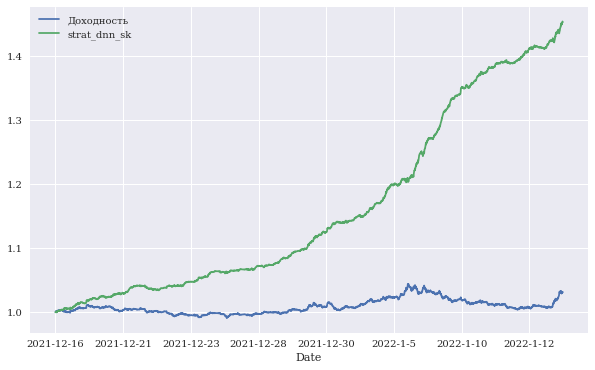

In [82]:
data[['Доходность', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [83]:
train, test = train_test_split(data, test_size=0.5, random_state=100) 

In [84]:
train = train.copy().sort_index() 

In [85]:
test = test.copy().sort_index()

In [86]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=3 * [500], random_state=1)

In [87]:
%time model.fit(train[cols_bin ], train['Направление'])

Wall time: 5min 14s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [88]:
test['pos_dnn_sk'] = model.predict(test[cols_bin]) 

In [89]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['Доходность'] 

In [90]:
test[['Доходность', 'strat_dnn_sk']].sum().apply(np.exp) 

Доходность      1.020265
strat_dnn_sk    0.998402
dtype: float64

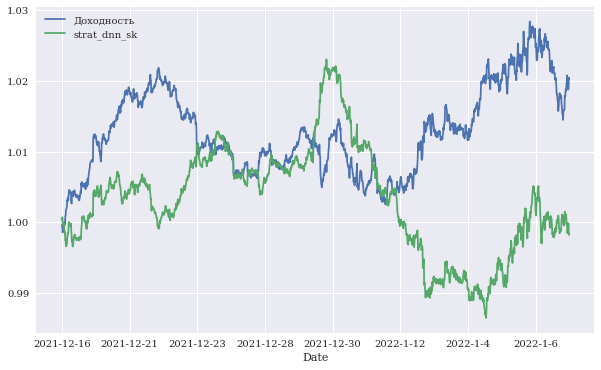

In [91]:
test[['Доходность', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));